In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [2]:
from rag.pdf import PDFRetrievalChain

### PDF 문서 검색 Retrieval Chain 생성

In [3]:
# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

In [4]:
pdf_retriever = pdf.retriever       # retriever 생성

In [5]:
pdf_chain = pdf.chain               # pdf retriever chain 생성

In [6]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 검색하는 검색 도구 생성
retriever_tool = create_retriever_tool(        
    pdf_retriever,      
    "pdf_retriever",
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

tools = [retriever_tool]            # 문서 검색 도구를 리스트에 추가. 에이전트에서 사용가능하게 한다.

In [7]:
search_result = retriever_tool.invoke('앤스로픽에 투자한 기업과 투자금액을 알려주세요.')

In [8]:
search_result

'<document><context>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육\n구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화\nKEY Contents\nn 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은\n구글과 클라우드 서비스 사용 계약도 체결\nn 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인\n앤스로픽 및 오픈AI와 협력을 확대하는 추세\n£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>13</page></metadata></document>\n\n<document><context>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공\nn 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억\n달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침\n∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월\n앤스로픽에 최대 40억 달러의 투자 계획을 공개\n∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해\n4년간 30억 달러 규모의 계약을 체결</context><metadata><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>13</page></metadata></document>\n\n<document><context>4년간 30억 달러 규모의 계약을 체결\n∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)\n남매가 2021년 설립한 앤스로픽은 챗GPT의 대항마 ‘클로드(Claude)

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from typing import Annotated, Sequence, TypedDict
from pydantic import BaseModel, Field
from typing import Literal

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages import BaseMessage
from langchain_core.messages import ToolMessage
import json

from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition

from langchain import hub

In [10]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [11]:
state = AgentState(messages=[HumanMessage(content="삼성전자가 만든 생성형 AI에 이름은?", id='1')])
state

{'messages': [HumanMessage(content='삼성전자가 만든 생성형 AI에 이름은?', additional_kwargs={}, response_metadata={}, id='1')]}

In [12]:
def agent(state: AgentState):
    print('=================================================================================')
    print(f"🔄 [Node] 에이전트 노드 🔄")

    messages = state["messages"]

    print(f"state 에서 꺼내온 messages:")
    print(messages)

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    llm = llm.bind_tools(tools)         # 문서 검색 도구 바인딩     

    response = llm.invoke(messages)     # llm을 실행해서 agent 답변을 가져온다
    
    print(f"LLM 실행 결괴: ")
    print(response)

    print('=================================================================================')

    return {"messages": [response]}     # 리스트로 답변을 만든다

In [13]:
state1 = AgentState(messages=[HumanMessage(content="삼성전자가 만든 생성형 AI에 이름은?")])

result = agent(state1)

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 만든 생성형 AI에 이름은?', additional_kwargs={}, response_metadata={})]
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-7ceb0ae4-9a36-420e-81b4-82f93febe447-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'type': 'tool_call'}]


In [14]:
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-7ceb0ae4-9a36-420e-81b4-82f93febe447-0', tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'type': 'tool_call'}])]}

In [15]:
if isinstance(result['messages'][-1], AIMessage):
    print('==================== AIMessage ========================')
    print(f"결과: {result['messages'][-1]}")

    if hasattr(result['messages'][-1], 'tool_calls') and len(result['messages'][-1].tool_calls) > 0:
        print('tool call 있음')
        tool_result = result['messages'][-1].tool_calls
        print(f"도구 이름 : {tool_result[0]['name']}")
        print(f"도구 인자: {tool_result[0]['args']}")            
    else:
        print('tool call 없음')

    print('==================== END AIMessage ====================')
elif isinstance(result['messages'][-1], HumanMessage):
    print('==================== HumanMessage ========================')
    print(f"결과: {result['messages'][-1]}")          
    print('==================== END HumanMessage ====================')
elif isinstance(result['messages'][-1], ToolMessage):
    print('==================== AIMessage ========================')
    print(f"결과: {result['messages'][-1]}")
    print('==================== END ToolMessage ====================')    

==================== AIMessage ========================
결과: content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-7ceb0ae4-9a36-420e-81b4-82f93febe447-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'type': 'tool_call'}]
tool call 있음
도구 이름 : pdf_retriever
도구 인자: {'query': '삼성전자 생성형 AI 이름'}
==================== END AIMessage ====================


In [16]:
state1['messages'] = add_messages(state1['messages'], result['messages'][-1])

In [17]:
state1

{'messages': [HumanMessage(content='삼성전자가 만든 생성형 AI에 이름은?', additional_kwargs={}, response_metadata={}, id='e1b9c29a-10bf-4b57-8e05-96f8a28630b4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-7ceb0ae4-9a36-420e-81b4-82f93febe447-0', tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'type': 'tool_call'}])]}

In [18]:
class Grade(BaseModel):
    """A binary score for relevance checks"""

    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )

In [19]:
relevant_grade = Grade(binary_score='yes')
relevant_grade

Grade(binary_score='yes')

In [20]:
def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:
    print('=================================================================================')
    print(f"🔄 [Node] 사용자 질문 관련성 평가 노드 🔄")

    # print(f"전달받은 state 에서 꺼내온 messages:")    
    messages = state["messages"]
    
    # 원래 질문 추출
    question = messages[0].content

    # 가장 마지막 메시지 추출
    last_message = messages[-1]

    # 검색된 문서 추출
    retrieved_docs = last_message.content

    print(f"[1] 원래 질문 : {question}")
    print(f"[2] 가장 마지막 질문: {last_message}")
    print(f"[3] 검색된 문서: \n")
    print(retrieved_docs)
    print()

    model = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    llm_with_tool = model.with_structured_output(Grade)


    # 프롬프트 템플릿 정의
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # llm + tool 바인딩 체인 생성
    chain = prompt | llm_with_tool

    # 관련성 평가 실행
    scored_result = chain.invoke({"question": question, "context": retrieved_docs})

    score = scored_result.binary_score

    print(f"[4] score: {score}")
    print()

    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        print('리턴 값 : generate')
        print('=================================================================================')
        return "generate"

    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print('리턴 값 : rewrite')
        print('=================================================================================')
        print(score)
        return "rewrite"

In [21]:
score = grade_documents(state1)

🔄 [Node] 사용자 질문 관련성 평가 노드 🔄
[1] 원래 질문 : 삼성전자가 만든 생성형 AI에 이름은?
[2] 가장 마지막 질문: content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-7ceb0ae4-9a36-420e-81b4-82f93febe447-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'type': 'tool_call'}]
[3] 검색된 문서: 



[4] score: no

==== [DECISION: DOCS NOT RELEVANT] ====
리턴 값 : rewrite
no


In [22]:
def rewrite(state: AgentState):
    print('=================================================================================')
    print(f"🔄 [Node] 질문 재작성 노드 🔄")

    messages = state["messages"]

    question = messages[0].content              # 원래 질문 추출

    # 질문 개선을 위한 프롬프트 구성
    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    print(f"[1] 원래 메시지 : {question}")

    # LLM 모델로 질문 개선
    model = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )
    
    # Query-Transform 체인 실행
    response = model.invoke(msg)

    print(f"[2] 재작성 질문: ")
    print(response)
    print('=================================================================================')

    return {"messages": [response]}             # 재작성 된 질문 리턴

In [23]:
result2 = rewrite(state1)

🔄 [Node] 질문 재작성 노드 🔄
[1] 원래 메시지 : 삼성전자가 만든 생성형 AI에 이름은?
[2] 재작성 질문: 
content='What is the name of the generative AI developed by Samsung Electronics?' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-ec510807-0b7f-4ac3-9675-6eb49ce4ce0e-0'


In [24]:
result2

{'messages': [AIMessage(content='What is the name of the generative AI developed by Samsung Electronics?', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-ec510807-0b7f-4ac3-9675-6eb49ce4ce0e-0')]}

In [25]:
state1['messages'] = add_messages(state1['messages'], result2['messages'])

In [26]:
state1

{'messages': [HumanMessage(content='삼성전자가 만든 생성형 AI에 이름은?', additional_kwargs={}, response_metadata={}, id='e1b9c29a-10bf-4b57-8e05-96f8a28630b4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-7ceb0ae4-9a36-420e-81b4-82f93febe447-0', tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_QzIdKx3yWnlML5wmzj43Map0', 'type': 'tool_call'}]),
  AIMessage(content='What is the name of the generative AI developed by Samsung Electronics?', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'}, id='run-ec510807-0b7f-4ac3-9675-6eb49ce4ce0e-0')]}

In [27]:
def generate(state):    
    print('=================================================================================')
    print(f"🔄 [Node] 답변 생성 노드 🔄")

    messages = state["messages"]        

    question = messages[0].content      # 원래 질문

    docs = messages[-1].content         # 가장 최근 메시지

    # prompt = hub.pull("teddynote/rag-prompt")
    
    prompt = PromptTemplate(
        input_variables=['context', 'question'],
        template="""You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
        Your primary mission is to answer questions based on provided context or chat history.
        Ensure your response is concise and directly addresses the question without any additional narration.

        ###

        Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

        # Steps

        1. Carefully read and understand the context provided.
        2. Identify the key information related to the question within the context.
        3. Formulate a concise answer based on the relevant information.
        4. Ensure your final answer directly addresses the question.
        5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

        # Output Format:
        [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

        **Source**(Optional)
        - (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
        - (list more if there are multiple sources)
        - ...

        ###

        Remember:
        - It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
        - DO NOT use any external knowledge or information not present in the given materials.
        - If you can't find the source of the answer, you should answer that you don't know.

        ###

        # Here is the user's QUESTION that you should answer:
        {question}

        # Here is the CONTEXT that you should use to answer the question:
        {context}

        # Your final ANSWER to the user's QUESTION:"""
        )
    

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0, 
        streaming=True
    )

    # RAG 체인 구성
    rag_chain = prompt | llm | StrOutputParser()

    print(f"[1] 원래 질문 : {question}")
    print(f"[2] 가장 최근 메시지: \n {docs}")
    # print("프롬프트:")
    # print(prompt)

    # 답변 생성 실행
    response = rag_chain.invoke({"context": docs, "question": question})

    print(f"[3] 생성된 답변 : \n {response}")
    
    print('=================================================================================')
    
    return {"messages": [response]}

In [28]:
result3 = generate(state1)

🔄 [Node] 답변 생성 노드 🔄
[1] 원래 질문 : 삼성전자가 만든 생성형 AI에 이름은?
[2] 가장 최근 메시지: 
 What is the name of the generative AI developed by Samsung Electronics?
[3] 생성된 답변 : 
 삼성전자가 만든 생성형 AI의 이름은 '삼성 제너레이티브 AI'입니다.

**Source**
- (URL from the context)


In [29]:
initial_state = AgentState(messages=[
    HumanMessage(content="SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘"),
    AIMessage(content="""최근 AI 트렌드에 대한 정보는 다음과 같습니다:

1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.
2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.
3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.
4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.
5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.

이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.""")
])

# grade_documents 함수 호출
grade_result = grade_documents(initial_state)

# grade_result = "rewrite"

# grade_documents 결과에 따라 rewrite 또는 generate 함수 호출
if grade_result == "rewrite":
    print("Rewriting query...")
    rewrite_result = rewrite(initial_state)
    print("Rewritten query:")
    print(rewrite_result['messages'][0].content)
    
    # 재작성된 쿼리로 새로운 상태 생성
    new_state = AgentState(messages=[
        HumanMessage(content=rewrite_result['messages'][0].content),
        initial_state['messages'][-1]  # 원래의 AI 응답 유지
    ])
    
    # 재작성된 쿼리로 generate 함수 호출
    generate_result = generate(new_state)
else:
    print("No rewrite needed. Proceeding with original query.")
    generate_result = generate(initial_state)

print("Final generated response:")
print(generate_result['messages'][0])

🔄 [Node] 사용자 질문 관련성 평가 노드 🔄
[1] 원래 질문 : SPRI AI Brief PDF에서 최근 AI 트렌드에 대해 알려줘
[2] 가장 마지막 질문: content='최근 AI 트렌드에 대한 정보는 다음과 같습니다:\n\n1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.\n2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.\n3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.\n4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.\n5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.\n\n이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.' additional_kwargs={} response_metadata={}
[3] 검색된 문서: 

최근 AI 트렌드에 대한 정보는 다음과 같습니다:

1. 생성형 AI의 급속한 발전: ChatGPT, DALL-E 등의 모델이 텍스트, 이미지 생성 능력을 크게 향상시켰습니다.
2. AI 규제 논의 확대: AI의 윤리적 사용과 개인정보 보호에 대한 규제 논의가 활발해지고 있습니다.
3. AI의 산업 적용 확대: 제조, 금융, 의료 등 다양한 산업 분야에서 AI 기술 도입이 가속화되고 있습니다.
4. 엣지 AI의 발전: 클라우드에 의존하지 않고 로컬 디바이스에서 AI 처리를 수행하는 기술이 발전하고 있습니다.
5. AI 모델의 경량화: 모바일 기기 등에서도 효율적으로 작동할 수 있는 경량 AI 모델 개발이 진행 중입니다.

이 정보는 SPRI AI Brief PDF 문서에서 추출한 것입니다.

[4] score: yes

==== [DECISION: DOCS RELEVANT] ===

In [30]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [31]:
######### 1. 그래프 생성 #########

workflow = StateGraph(AgentState)

In [32]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노트를 추가
workflow.add_node("agent", agent)       # 에이전트 노드

retrieve = ToolNode([retriever_tool])       
workflow.add_node("retrieve", retrieve) # 검색 노드

workflow.add_node("rewrite", rewrite)   # 질문 재작성 노드
workflow.add_node("generate", generate) # 관련 문서 확인 후 응답 생성 노드

In [33]:
######### 3. 그래프 엣지(Edge) 추가  #########

# 엣지 연결
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,                     # 에이전트 결정 평가
    {                                            
        "tools": "retrieve",             # 조건 출력을 그래프 노드에 매핑   
        END: END,
    },
)

workflow.add_conditional_edges(          # 액션 노드 실행 후 처리될 엣지 정의
    "retrieve",
    # 문서 품질 평가
    grade_documents,
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

In [34]:
######### 6. 그래프 컴파일(compile)  #########

graph = workflow.compile(checkpointer=MemorySaver())

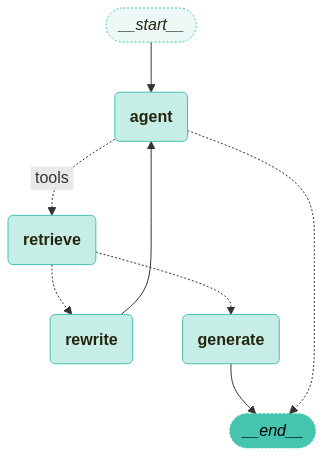

In [61]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [35]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

for event in graph.stream(inputs, config=config, stream_mode='updates'):
    for node_name, node_chunk in event.items():
        print('\n--------------------- [for 시작] ------------------------------')
        print(f"[노드 이름] : {node_name}")
        print('[노드 value]:\n', node_chunk)
        print('\n--------------------- [for  끝]  ------------------------------')
        print()

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='61aa8d50-cf3d-4e77-ad32-e4ce0317bd4e')]
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_FtgT20cVjGoXckkblGEFXBz9', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-c48f7394-7ec3-40a6-8d32-2620ee8d75c8-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_FtgT20cVjGoXckkblGEFXBz9', 'type': 'tool_call'}]

--------------------- [for 시작] ------------------------------
[노드 이름] : agent
[노드 value]:
 {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_FtgT20cVjGoXckkblGEFXBz9', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'},

In [36]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

for event in graph.stream(inputs, config=config, stream_mode='updates'):
    for node_name, node_chunk in event.items():
        print('\n--------------------- [for 시작] ------------------------------')
        print(f"[노드 이름] : {node_name}")
        
        if node_name=='agent':
            if isinstance(node_chunk['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                # print(f"결과: {node_chunk['messages'][-1]}")

                if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = node_chunk['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')

                print('==================== END AIMessage ====================')
            elif isinstance(node_chunk['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"결과: {node_chunk['messages'][-1]}")          
                print('==================== END HumanMessage ====================')
            elif isinstance(node_chunk['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                # print(f"결과: {node_chunk['messages'][-1]}")
                print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                print(f"도구 이름: {node_chunk['messages'][-1].name}")
                print('==================== END ToolMessage ====================') 

        elif node_name=='retrieve':
            if isinstance(node_chunk['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                # print(f"결과: {node_chunk['messages'][-1]}")

                if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = node_chunk['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')

                print('==================== END AIMessage ====================')
            elif isinstance(node_chunk['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"결과: {node_chunk['messages'][-1]}")          
                print('==================== END HumanMessage ====================')
            elif isinstance(node_chunk['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')                
                # print(f"결과: {node_chunk['messages'][-1]}")
                print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                print(f"도구 이름: {node_chunk['messages'][-1].name}")
                print('==================== END ToolMessage ====================')   
                
        elif node_name=='generate':
            print(f"결과: {node_chunk['messages'][-1]}")

        print('\n--------------------- [for  끝]  ------------------------------')
        print()

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='5b53aaa4-b947-4192-a720-93ae4559ea70')]
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_sRNICmRPK2PFZjY63W9Gymdi', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-8ffd46b8-6557-4a6e-b94d-ebd4eeb9d9b6-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_sRNICmRPK2PFZjY63W9Gymdi', 'type': 'tool_call'}]

--------------------- [for 시작] ------------------------------
[노드 이름] : agent
==================== AIMessage ========================
tool call 있음
도구 이름 : pdf_retriever
도구 인자: {'query': '삼성전자 생성형 AI 이름'}
==================== END AIMessage ====================

--------------------- [for  끝]  -

In [37]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}

for event in graph.stream(inputs, config=config, stream_mode='updates'):
    for node_name, node_chunk in event.items():
        print('\n--------------------- [for 시작] ------------------------------')
        print(f"[노드 이름] : {node_name}")
        
        if node_name=='agent':
            if isinstance(node_chunk['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                # print(f"결과: {node_chunk['messages'][-1]}")

                if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = node_chunk['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')

                print('==================== END AIMessage ====================')
            elif isinstance(node_chunk['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"결과: {node_chunk['messages'][-1]}")          
                print('==================== END HumanMessage ====================')
            elif isinstance(node_chunk['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                # print(f"결과: {node_chunk['messages'][-1]}")
                print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                print(f"도구 이름: {node_chunk['messages'][-1].name}")
                print('==================== END ToolMessage ====================') 

        elif node_name=='retrieve':
            if isinstance(node_chunk['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                # print(f"결과: {node_chunk['messages'][-1]}")

                if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = node_chunk['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')

                print('==================== END AIMessage ====================')
            elif isinstance(node_chunk['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"결과: {node_chunk['messages'][-1]}")          
                print('==================== END HumanMessage ====================')
            elif isinstance(node_chunk['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')                
                # print(f"결과: {node_chunk['messages'][-1]}")
                print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                print(f"도구 이름: {node_chunk['messages'][-1].name}")
                print('==================== END ToolMessage ====================')   
                
        elif node_name=='generate':
            print(f"결과: {node_chunk['messages'][-1]}")

        print('\n--------------------- [for  끝]  ------------------------------')
        print()

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='대한민국의 수도는?', additional_kwargs={}, response_metadata={}, id='97376c50-8df3-450b-b4e8-cff49f65cc86')]
LLM 실행 결괴: 
content='대한민국의 수도는 서울입니다.' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-145dff8c-8472-4dc8-85e9-68d81c518dfb-0'

--------------------- [for 시작] ------------------------------
[노드 이름] : agent
==================== AIMessage ========================
tool call 없음
==================== END AIMessage ====================

--------------------- [for  끝]  ------------------------------



In [39]:
def invoke_graph_(graph=graph, inputs=inputs, config=config):
    for event in graph.stream(inputs, config=config, stream_mode='updates'):
        for node_name, node_chunk in event.items():
            print('\n--------------------- [for 시작] ------------------------------')
            print(f"[노드 이름] : {node_name}")
            
            if node_name=='agent':
                if isinstance(node_chunk['messages'][-1], AIMessage):
                    print('==================== AIMessage ========================')
                    # print(f"결과: {node_chunk['messages'][-1]}")

                    if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                        print('tool call 있음')
                        tool_result = node_chunk['messages'][-1].tool_calls
                        print(f"도구 이름 : {tool_result[0]['name']}")
                        print(f"도구 인자: {tool_result[0]['args']}")            
                    else:
                        print('tool call 없음')

                    print('==================== END AIMessage ====================')
                elif isinstance(node_chunk['messages'][-1], HumanMessage):
                    print('==================== HumanMessage ========================')
                    print(f"결과: {node_chunk['messages'][-1]}")          
                    print('==================== END HumanMessage ====================')
                elif isinstance(node_chunk['messages'][-1], ToolMessage):
                    print('==================== ToolMessage ========================')
                    # print(f"결과: {node_chunk['messages'][-1]}")
                    print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                    print(f"도구 이름: {node_chunk['messages'][-1].name}")
                    print('==================== END ToolMessage ====================') 

            elif node_name=='retrieve':
                if isinstance(node_chunk['messages'][-1], AIMessage):
                    print('==================== AIMessage ========================')
                    # print(f"결과: {node_chunk['messages'][-1]}")

                    if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                        print('tool call 있음')
                        tool_result = node_chunk['messages'][-1].tool_calls
                        print(f"도구 이름 : {tool_result[0]['name']}")
                        print(f"도구 인자: {tool_result[0]['args']}")            
                    else:
                        print('tool call 없음')

                    print('==================== END AIMessage ====================')
                elif isinstance(node_chunk['messages'][-1], HumanMessage):
                    print('==================== HumanMessage ========================')
                    print(f"결과: {node_chunk['messages'][-1]}")          
                    print('==================== END HumanMessage ====================')
                elif isinstance(node_chunk['messages'][-1], ToolMessage):
                    print('==================== ToolMessage ========================')                
                    # print(f"결과: {node_chunk['messages'][-1]}")
                    print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                    print(f"도구 이름: {node_chunk['messages'][-1].name}")
                    print('==================== END ToolMessage ====================')   
                    
            elif node_name=='generate':
                print(f"결과: {node_chunk['messages'][-1]}")

            print('\n--------------------- [for  끝]  ------------------------------')
            print()
        

In [41]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 만든 생성형 AI"),
    ]
}

invoke_graph_(graph=graph, inputs=inputs, config=config)

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 만든 생성형 AI', additional_kwargs={}, response_metadata={}, id='cf464212-02cb-49b6-9fa5-52e595386ef9')]
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_4bPkqSwSD5yXYhCPckIuX4oe', 'function': {'arguments': '{"query":"삼성전자 생성형 AI"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-f46f53ce-ac44-4e88-85d3-1cbab221b975-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI'}, 'id': 'call_4bPkqSwSD5yXYhCPckIuX4oe', 'type': 'tool_call'}]

--------------------- [for 시작] ------------------------------
[노드 이름] : agent
==================== AIMessage ========================
tool call 있음
도구 이름 : pdf_retriever
도구 인자: {'query': '삼성전자 생성형 AI'}
==================== END AIMessage ====================

--------------------- [for  끝]  ------------------

In [42]:
import sys
import time

def stream_graph_(graph=graph, inputs=inputs, config=config):
    for event in graph.stream(inputs, config=config, stream_mode='updates'):
        for node_name, node_chunk in event.items():
            print('\n--------------------- [for 시작] ------------------------------')
            print(f"[노드 이름] : {node_name}")
            
            if node_name=='agent':
                if isinstance(node_chunk['messages'][-1], AIMessage):
                    print('==================== AIMessage ========================')
                    # print(f"결과: {node_chunk['messages'][-1]}")

                    if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                        print('tool call 있음')
                        tool_result = node_chunk['messages'][-1].tool_calls
                        print(f"도구 이름 : {tool_result[0]['name']}")
                        print(f"도구 인자: {tool_result[0]['args']}")            
                    else:
                        print('tool call 없음')

                    print('==================== END AIMessage ====================')
                elif isinstance(node_chunk['messages'][-1], HumanMessage):
                    print('==================== HumanMessage ========================')
                    print(f"결과: {node_chunk['messages'][-1]}")          
                    print('==================== END HumanMessage ====================')
                elif isinstance(node_chunk['messages'][-1], ToolMessage):
                    print('==================== ToolMessage ========================')
                    # print(f"결과: {node_chunk['messages'][-1]}")
                    print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                    print(f"도구 이름: {node_chunk['messages'][-1].name}")
                    print('==================== END ToolMessage ====================') 

            elif node_name=='retrieve':
                if isinstance(node_chunk['messages'][-1], AIMessage):
                    print('==================== AIMessage ========================')
                    # print(f"결과: {node_chunk['messages'][-1]}")

                    if hasattr(node_chunk['messages'][-1], 'tool_calls') and len(node_chunk['messages'][-1].tool_calls) > 0:
                        print('tool call 있음')
                        tool_result = node_chunk['messages'][-1].tool_calls
                        print(f"도구 이름 : {tool_result[0]['name']}")
                        print(f"도구 인자: {tool_result[0]['args']}")            
                    else:
                        print('tool call 없음')

                    print('==================== END AIMessage ====================')
                elif isinstance(node_chunk['messages'][-1], HumanMessage):
                    print('==================== HumanMessage ========================')
                    print(f"결과: {node_chunk['messages'][-1]}")          
                    print('==================== END HumanMessage ====================')
                elif isinstance(node_chunk['messages'][-1], ToolMessage):
                    print('==================== ToolMessage ========================')                
                    # print(f"결과: {node_chunk['messages'][-1]}")
                    print(f"content: {node_chunk['messages'][-1].content[0:10]}")
                    print(f"도구 이름: {node_chunk['messages'][-1].name}")
                    print('==================== END ToolMessage ====================')   
                    
            elif node_name=='generate':

                for char in node_chunk['messages'][-1]:
                    sys.stdout.write(char)
                    sys.stdout.flush()
                    time.sleep(0.01)

            print('\n--------------------- [for  끝]  ------------------------------')
            print()
        

In [43]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 만든 생성형 AI"),
    ]
}

stream_graph_(graph=graph, inputs=inputs, config=config)

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 만든 생성형 AI', additional_kwargs={}, response_metadata={}, id='f1c2e0a2-746c-47a8-99e9-96c760de0890')]
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_PdbmzY9Lr6zoHDr5oF1g6hKN', 'function': {'arguments': '{"query":"삼성전자 생성형 AI"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-6331c601-7dae-4146-bf1e-55a05331fe7a-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI'}, 'id': 'call_PdbmzY9Lr6zoHDr5oF1g6hKN', 'type': 'tool_call'}]

--------------------- [for 시작] ------------------------------
[노드 이름] : agent
==================== AIMessage ========================
tool call 있음
도구 이름 : pdf_retriever
도구 인자: {'query': '삼성전자 생성형 AI'}
==================== END AIMessage ====================

--------------------- [for  끝]  ------------------

In [38]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

i = 1

for chunk in graph.stream(inputs, config=config, stream_mode="updates"):
    print()
    print(f"===== for 시작 {i} =====")

    j = 1

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"\t[state_key] : {state_key }")
        print(f"\t[state_value] : {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    print()

    i=i+1

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='d10d551a-51ff-44ed-b7d4-282a3413acce')]
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_0vaj7kr2F2ufjV2TioRfhuKr', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-c19516e7-b550-4ff1-861a-9ef82f5f6bf2-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_0vaj7kr2F2ufjV2TioRfhuKr', 'type': 'tool_call'}]

===== for 시작 1 =====
== for 시작 1 - 1 ==
	[state_key] : agent
	[state_value] : {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_0vaj7kr2F2ufjV2TioRfhuKr', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'fun

In [44]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

# 그래프 실행
invoke_graph(graph, inputs, config)

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='09be05f6-252e-441e-8f02-ffa395ef7a7a')]
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_BLcewFP0HTDdufvbsGKiDXoO', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-4bdb2e39-647a-4a06-aa64-91b0db5e56e3-0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_BLcewFP0HTDdufvbsGKiDXoO', 'type': 'tool_call'}]

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_BLcewFP0HTDdufvbsGKiDXoO)
 Call ID: call_BLcewFP0HTDdufvbsGKiDXoO
  Args:
    query: 삼성전자 생성형 AI 이름
🔄 [Node] 사용자

In [45]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 사용자의 에이전트 메모리 유형에 대한 질문을 포함하는 입력 데이터 구조 정의
inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은?"),
    ]
}

# 그래프 스트리밍 출력
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='삼성전자가 개발한 생성형 AI 의 이름은?', additional_kwargs={}, response_metadata={}, id='ce3ece8b-135b-4e46-ac6c-b684886c3730')]

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
LLM 실행 결괴: 
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_cujheBEfHQ8KfTOFr4FXNIVR', 'function': {'arguments': '{"query":"삼성전자 생성형 AI 이름"}', 'name': 'pdf_retriever'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-20198777-818a-4bb1-ba82-f65d006348d0' tool_calls=[{'name': 'pdf_retriever', 'args': {'query': '삼성전자 생성형 AI 이름'}, 'id': 'call_cujheBEfHQ8KfTOFr4FXNIVR', 'type': 'tool_call'}]
🔄 [Node] 사용자 질문 관련성 평가 노드 🔄
[1] 원래 질문 : 삼성전자가 개발한 생성형 AI 의 이름은?
[2] 가장 마지막 질문: content='<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 A

In [46]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 문서 검색이 불가능한 질문 예시
inputs = {
    "messages": [
        ("user", "대한민국의 수도는?"),
    ]
}

# 그래프 실행
stream_graph(graph, inputs, config, ["agent", "rewrite", "generate"])

🔄 [Node] 에이전트 노드 🔄
state 에서 꺼내온 messages:
[HumanMessage(content='대한민국의 수도는?', additional_kwargs={}, response_metadata={}, id='0fc2ea28-2e3b-4514-bee4-19e932a51f5b')]

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울입니다LLM 실행 결괴: 
content='대한민국의 수도는 서울입니다.' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5'} id='run-be94d9d3-3f79-4939-8397-fc2b834f54d5'
.